## **Section 1: Import libraries**

In [29]:
!pip install tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## **Section 2: Load data**

In [30]:
data = pd.read_csv('data.csv')

In [31]:
data.head()

,Data.Precipitation,Date.Full,Date.Month,Date.Week of,Date.Year,Station.City,Station.Code,Station.Location,Station.State,Data.Temperature.Avg Temp,Data.Temperature.Max Temp,Data.Temperature.Min Temp,Data.Wind.Direction,Data.Wind.Speed
0,0.00,2016-01-03,1,3,2016,Birmingham,BHM,"Birmingham, AL",Alabama,39,46,32,33,4.33
1,0.00,2016-01-03,1,3,2016,Huntsville,HSV,"Huntsville, AL",Alabama,39,47,31,32,3.86
2,0.16,2016-01-03,1,3,2016,Mobile,MOB,"Mobile, AL",Alabama,46,51,41,35,9.73
3,0.00,2016-01-03,1,3,2016,Montgomery,MGM,"Montgomery, AL",Alabama,45,52,38,32,6.86
4,0.01,2016-01-03,1,3,2016,Anchorage,ANC,"Anchorage, AK",Alaska,34,38,29,19,7.80


## **Section 3: Preprocessing**

###***Section 3.1: Select features and split data***

In [32]:
# Select only the desired features
features_to_select = [
    'Date.Year',
    'Date.Month',
    'Data.Temperature.Avg Temp',
    'Data.Temperature.Max Temp',
    'Data.Temperature.Min Temp',
    'Data.Wind.Direction',
    'Data.Wind.Speed',
    'Data.Precipitation'
]
data_selected = data[features_to_select].copy()

In [33]:
# Split data into train/validation (year 2016) and test (year 2017)
train_val_data = data_selected[data_selected['Date.Year'] == 2016].copy()
test_data = data_selected[data_selected['Date.Year'] == 2017].copy()

# Drop the 'Date.Year' column (not used as a feature)
train_val_data.drop('Date.Year', axis=1, inplace=True)
test_data.drop('Date.Year', axis=1, inplace=True)

In [34]:
# Split train/validation: 80% for training, 20% for validation
val_split_index = int(len(train_val_data) * 0.8)
train_data = train_val_data[:val_split_index].copy()
val_data = train_val_data[val_split_index:].copy()

###***Section 3.2: Process wind direction and date features for cyclical encoding***

In [35]:
# Process wind direction and date features for cyclical encoding
for df in [train_data, val_data, test_data]:
    # Convert wind direction to numeric and create cyclical features for wind direction
    # Check if 'Data.Wind.Direction' column exists before processing
    if 'Data.Wind.Direction' in df.columns:
        df['Data.Wind.Direction'] = pd.to_numeric(df['Data.Wind.Direction'], errors='coerce')
        df['Data.Wind.Direction'].fillna(0, inplace=True)
        df['Data.Wind.Direction'] = df['Data.Wind.Direction'] % 360
        df['wind_dir_sin'] = np.sin(np.deg2rad(df['Data.Wind.Direction']))
        df['wind_dir_cos'] = np.cos(np.deg2rad(df['Data.Wind.Direction']))
        df.drop('Data.Wind.Direction', axis=1, inplace=True)

    # Create cyclical encoding for Date.Month
    # Check if 'Date.Month' column exists before processing
    if 'Date.Month' in df.columns:
        df['month_sin'] = np.sin(2 * np.pi * df['Date.Month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['Date.Month'] / 12)
        # Drop the original Date.Month column as we now use cyclical features
        df.drop('Date.Month', axis=1, inplace=True)

<ipython-input-35-1e2dbd9103d0>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Data.Wind.Direction'].fillna(0, inplace=True)
<ipython-input-35-1e2dbd9103d0>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

###***Section 3.3: Scaling input features and target***

In [36]:
# Define the input features for the model:
# We include cyclical encoded date features, temperature features, and wind speed.
# (Note: The cyclical features 'month_sin' and 'month_cos' are already in a comparable range, so no scaling is applied)
input_features = ['month_sin', 'month_cos',
                  'Data.Temperature.Avg Temp',
                  'Data.Temperature.Max Temp',
                  'Data.Temperature.Min Temp',
                  'Data.Wind.Speed']

# Define the columns to scale (only continuous numeric features except cyclical ones)
scaling_cols = ['Data.Temperature.Avg Temp', 'Data.Temperature.Max Temp', 'Data.Temperature.Min Temp', 'Data.Wind.Speed']

In [37]:
# Create a scaler for the input features (fit only on train_data)
input_scaler = StandardScaler()
train_data[scaling_cols] = input_scaler.fit_transform(train_data[scaling_cols])
val_data[scaling_cols] = input_scaler.transform(val_data[scaling_cols])
test_data[scaling_cols] = input_scaler.transform(test_data[scaling_cols])

# Create a scaler for the target variable (Data.Precipitation)
target_scaler = StandardScaler()
# Create a new column for the scaled target
train_data['Data.Precipitation_scaled'] = target_scaler.fit_transform(train_data[['Data.Precipitation']])
val_data['Data.Precipitation_scaled'] = target_scaler.transform(val_data[['Data.Precipitation']])
test_data['Data.Precipitation_scaled'] = target_scaler.transform(test_data[['Data.Precipitation']])

## **Section 4: Create data generator**

In [85]:
# Define time series parameters
n_steps = 14
batch_size = 64

In [86]:
# Create data generators for training, validation, and test using the selected input features and target
train_data_gen = keras.preprocessing.timeseries_dataset_from_array(
    data=train_data[input_features].values,
    targets=train_data['Data.Precipitation_scaled'].values,
    sequence_length=n_steps,
    batch_size=batch_size,
    shuffle=True
)

val_data_gen = keras.preprocessing.timeseries_dataset_from_array(
    data=val_data[input_features].values,
    targets=val_data['Data.Precipitation_scaled'].values,
    sequence_length=n_steps,
    batch_size=batch_size,
    shuffle=False
)

test_data_gen = keras.preprocessing.timeseries_dataset_from_array(
    data=test_data[input_features].values,
    targets=test_data['Data.Precipitation_scaled'].values,
    sequence_length=n_steps,
    batch_size=batch_size,
    shuffle=False
)

## **Section 5: Define model**

In [108]:
# The number of features used in the generator is now 6
num_features = len(input_features)

# Define number of EarlyStopping patiene
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### ***Section 5.1: Model with LSTM units: 16***

In [109]:
model16 = keras.Sequential([
    keras.layers.Input(shape=(n_steps, num_features)),
    keras.layers.LSTM(16),
    keras.layers.Dense(1)
])
model16.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 16)                  │           1,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,489 (5.82 KB)

 Trainable params: 1,489 (5.82 KB)

 Non-trainable params: 0 (0.00 B)

### ***Section 5.2: Model with LSTM units: 32***

In [110]:
model32 = keras.Sequential([
    keras.layers.Input(shape=(n_steps, num_features)),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)
])
model32.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 32)                  │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,025 (19.63 KB)

 Trainable params: 5,025 (19.63 KB)

 Non-trainable params: 0 (0.00 B)

### ***Section 5.3: Model with LSTM units: 64***

In [111]:
model64 = keras.Sequential([
    keras.layers.Input(shape=(n_steps, num_features)),
    keras.layers.LSTM(64),
    keras.layers.Dense(1)
])
model64.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

### ***Section 5.4: Model with LSTM units: 128***

In [112]:
model128 = keras.Sequential([
    keras.layers.Input(shape=(n_steps, num_features)),
    keras.layers.LSTM(128),
    keras.layers.Dense(1)
])
model128.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 128)                 │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,249 (270.50 KB)

 Trainable params: 69,249 (270.50 KB)

 Non-trainable params: 0 (0.00 B)

## **Section 6: Compile model**

In [113]:
# Define Learning rate
learning_rate=0.0001

In [114]:
# Compile the models with the same configuration:
# Model with 16 LSTM units
model16.compile(loss='mse',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['mae'])

# Model with 32 LSTM units
model32.compile(loss='mse',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['mae'])

# Model with 64 LSTM units
model64.compile(loss='mse',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['mae'])

# Model with 128 LSTM units
model128.compile(loss='mse',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['mae'])

## **Section 7: Train model**

In [115]:
# Define model training parameters
epochs=50
callbacks=[early_stopping]

### ***Section 7.1: Train the model with 16 LSTM units***

In [116]:
# Train the model with 16 LSTM units:
history16 = model16.fit(train_data_gen,
                        epochs=epochs,
                        validation_data=val_data_gen,
                        callbacks=callbacks,
                        verbose=1)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.1483 - mae: 0.6685 - val_loss: 0.7517 - val_mae: 0.5861
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0972 - mae: 0.6481 - val_loss: 0.7430 - val_mae: 0.5589
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0876 - mae: 0.6445 - val_loss: 0.7402 - val_mae: 0.5516
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1040 - mae: 0.6411 - val_loss: 0.7380 - val_mae: 0.5465
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0530 - mae: 0.6349 - val_loss: 0.7362 - val_mae: 0.5427
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0680 - mae: 0.6358 - val_loss: 0.7347 - val_mae: 0.5417
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1196 - mae: 0.6392 - val_loss: 0.7332 - val_mae: 0.5404
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0218 - mae: 0.6275 - val_loss: 0.7318 - val_mae: 0.5381
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - l

### ***Section 7.2: Train the model with 32 LSTM units***

In [118]:
# Train the model with 32 LSTM units:
history32 = model32.fit(train_data_gen,
                        epochs=epochs,
                        validation_data=val_data_gen,
                        callbacks=callbacks,
                        verbose=1)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1103 - mae: 0.6431 - val_loss: 0.7361 - val_mae: 0.5407
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0818 - mae: 0.6361 - val_loss: 0.7337 - val_mae: 0.5389
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1068 - mae: 0.6406 - val_loss: 0.7328 - val_mae: 0.5334
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0950 - mae: 0.6362 - val_loss: 0.7302 - val_mae: 0.5303
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0563 - mae: 0.6315 - val_loss: 0.7283 - val_mae: 0.5266
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0929 - mae: 0.6325 - val_loss: 0.7251 - val_mae: 0.5226
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0604 - mae: 0.6269 - val_loss: 0.7224 - val_mae: 0.5197
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0303 - mae: 0.6226 - val_loss: 0.7188 - val_mae: 0.5150
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step -

### ***Section 7.3: Train the model with 64 LSTM units***

In [119]:
# Train the model with 64 LSTM units:
history64 = model64.fit(train_data_gen,
                        epochs=epochs,
                        validation_data=val_data_gen,
                        callbacks=callbacks,
                        verbose=1)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.0993 - mae: 0.6495 - val_loss: 0.7313 - val_mae: 0.5520
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0998 - mae: 0.6373 - val_loss: 0.7277 - val_mae: 0.5396
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0448 - mae: 0.6259 - val_loss: 0.7219 - val_mae: 0.5241
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0649 - mae: 0.6230 - val_loss: 0.7162 - val_mae: 0.5038
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0108 - mae: 0.6093 - val_loss: 0.7112 - val_mae: 0.4900
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0364 - mae: 0.6084 - val_loss: 0.7055 - val_mae: 0.4824
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0094 - mae: 0.6044 - val_loss: 0.7012 - val_mae: 0.4772
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9905 - mae: 0.5949 - val_loss: 0.6987 - val_mae: 0.4724
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/

### ***Section 7.4: Train the model with 128 LSTM units***

In [120]:
# Train the model with 128 LSTM units:
history128 = model128.fit(train_data_gen,
                        epochs=epochs,
                        validation_data=val_data_gen,
                        callbacks=callbacks,
                        verbose=1)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 1.0836 - mae: 0.6348 - val_loss: 0.7346 - val_mae: 0.5401
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.0888 - mae: 0.6331 - val_loss: 0.7215 - val_mae: 0.5188
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.0346 - mae: 0.6199 - val_loss: 0.7182 - val_mae: 0.4909
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.0070 - mae: 0.6046 - val_loss: 0.7062 - val_mae: 0.4794
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.0254 - mae: 0.5994 - val_loss: 0.7087 - val_mae: 0.4688
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.9954 - mae: 0.5943 - val_loss: 0.7053 - val_mae: 0.4669
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.0109 - mae: 0.5995 - val_loss: 0.6965 - val_mae: 0.4632
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.9475 - mae: 0.5848 - val_loss: 0.6889 - val_mae: 0.4616
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/

## **Section 8: Test model and print results**

In [121]:
# Create test samples manually from test_data (ใช้ input_features เดียวกันสำหรับทุกโมเดล)
test_samples = len(test_data) - n_steps
X_test = np.array([
    test_data[input_features].values[i:i+n_steps]
    for i in range(test_samples)
])
# Get true target values (scaled) and then convert to original scale
y_true_scaled = test_data['Data.Precipitation_scaled'].values[n_steps:].reshape(-1, 1)
y_true = target_scaler.inverse_transform(y_true_scaled)

### ***Section 8.1: Evaluate Model 16***

In [123]:
# Predict on the test set using the trained model (model16)
y_pred16_scaled = model16.predict(X_test)

# Inverse transform the scaled predictions to get the predictions in the original scale
y_pred16 = target_scaler.inverse_transform(y_pred16_scaled)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE) and R-squared (R²) score
mse16 = MeanSquaredError()(y_true, y_pred16).numpy()
mae16 = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred16).numpy()
r2_16 = r2_score(y_true, y_pred16)

print("LSTM 16 - MSE: ", mse16, "MAE: ", mae16, "R²: ", r2_16)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM 16 - MSE:  0.48792148 MAE:  0.5049512 R²:  -0.17104301259901744


### ***Section 8.2: Evaluate Model 32***

In [127]:
# Predict on the test set using the trained model (model32)
y_pred32_scaled = model32.predict(X_test)

# Inverse transform the scaled predictions to get the predictions in the original scale
y_pred32 = target_scaler.inverse_transform(y_pred32_scaled)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE) and R-squared (R²) score
mse32 = MeanSquaredError()(y_true, y_pred32).numpy()
mae32 = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred32).numpy()
r2_32 = r2_score(y_true, y_pred32)

print("LSTM 32 - MSE: ", mse32, "MAE: ", mae32, "R²: ", r2_32)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM 32 - MSE:  0.45775294 MAE:  0.4871932 R²:  -0.09863664661616434


### ***Section 8.3: Evaluate Model 64***

In [125]:
# Predict on the test set using the trained model (model64)
y_pred64_scaled = model64.predict(X_test)

# Inverse transform the scaled predictions to get the predictions in the original scale
y_pred64 = target_scaler.inverse_transform(y_pred64_scaled)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE) and R-squared (R²) score
mse64 = MeanSquaredError()(y_true, y_pred64).numpy()
mae64 = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred64).numpy()
r2_64 = r2_score(y_true, y_pred64)

print("LSTM 64 - MSE: ", mse64, "MAE: ", mae64, "R²: ", r2_64)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM 64 - MSE:  0.47432756 MAE:  0.50171477 R²:  -0.13841680612904184


### ***Section 8.4: Evaluate Model 128***

In [126]:
# Predict on the test set using the trained model (model128)
y_pred128_scaled = model128.predict(X_test)

# Inverse transform the scaled predictions to get the predictions in the original scale
y_pred128 = target_scaler.inverse_transform(y_pred128_scaled)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE) and R-squared (R²) score
mse128 = MeanSquaredError()(y_true, y_pred128).numpy()
mae128 = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred128).numpy()
r2_128 = r2_score(y_true, y_pred128)

print("LSTM 128 - MSE: ", mse128, "MAE: ", mae128, "R²: ", r2_128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM 128 - MSE:  0.4776152 MAE:  0.49873382 R²:  -0.1463074341788213


## **Section 9: Plot true vs predicted precipitation values**

###***Section 9.1: Plot Training & Validation Loss for Each Mode***

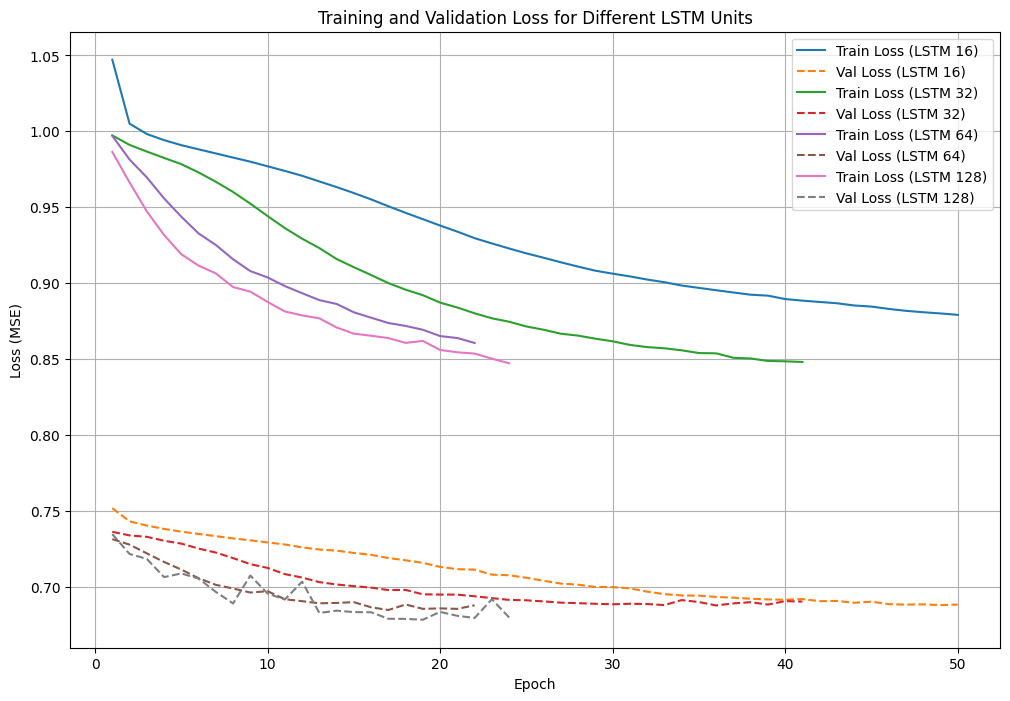

In [128]:
plt.figure(figsize=(12, 8))
# Plot for model 16
epochs16 = range(1, len(history16.history['loss']) + 1)
plt.plot(epochs16, history16.history['loss'], label='Train Loss (LSTM 16)')
plt.plot(epochs16, history16.history['val_loss'], '--', label='Val Loss (LSTM 16)')

# Plot for model 32
epochs32 = range(1, len(history32.history['loss']) + 1)
plt.plot(epochs32, history32.history['loss'], label='Train Loss (LSTM 32)')
plt.plot(epochs32, history32.history['val_loss'], '--', label='Val Loss (LSTM 32)')

# Plot for model 64
epochs64 = range(1, len(history64.history['loss']) + 1)
plt.plot(epochs64, history64.history['loss'], label='Train Loss (LSTM 64)')
plt.plot(epochs64, history64.history['val_loss'], '--', label='Val Loss (LSTM 64)')

# Plot for model 128
epochs128 = range(1, len(history128.history['loss']) + 1)
plt.plot(epochs128, history128.history['loss'], label='Train Loss (LSTM 128)')
plt.plot(epochs128, history128.history['val_loss'], '--', label='Val Loss (LSTM 128)')

plt.title('Training and Validation Loss for Different LSTM Units')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

###***Section 9.2: Plot True vs Predicted Precipitation for Each Model***

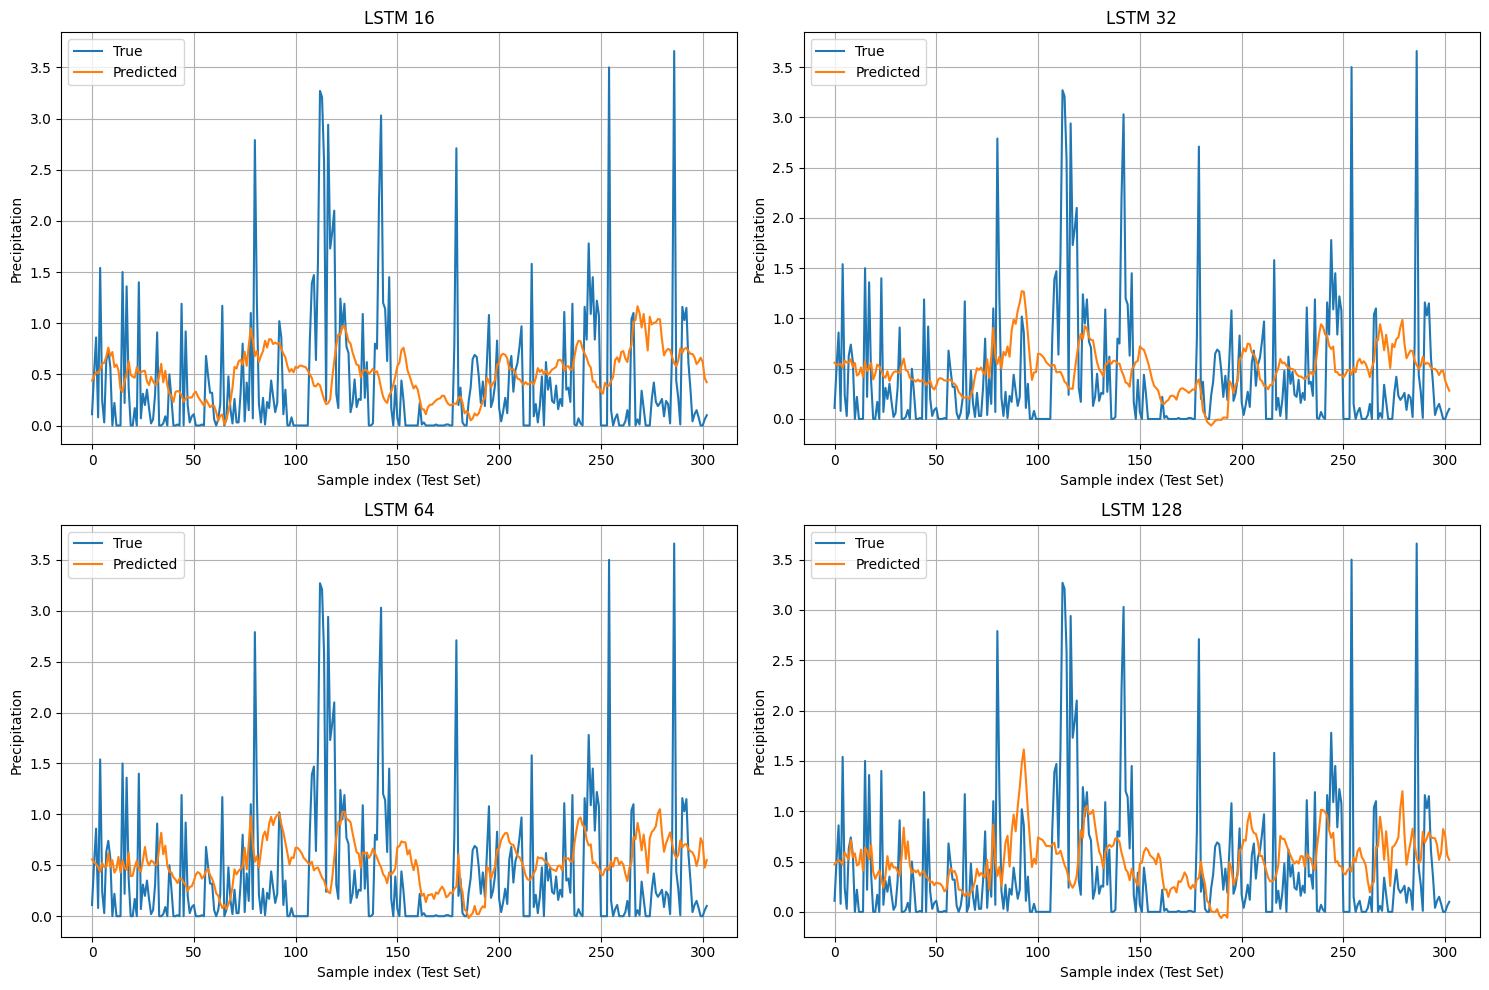

In [129]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(y_true, label='True')
plt.plot(y_pred16, label='Predicted')
plt.title('LSTM 16')
plt.xlabel('Sample index (Test Set)')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(y_true, label='True')
plt.plot(y_pred32, label='Predicted')
plt.title('LSTM 32')
plt.xlabel('Sample index (Test Set)')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(y_true, label='True')
plt.plot(y_pred64, label='Predicted')
plt.title('LSTM 64')
plt.xlabel('Sample index (Test Set)')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(y_true, label='True')
plt.plot(y_pred128, label='Predicted')
plt.title('LSTM 128')
plt.xlabel('Sample index (Test Set)')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()